In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')

In [ ]:
results_v01 = {
    "ours": {
        "directory":'../results/Dataset_v01/test/default',
        "format": '(.*)_img_pred_mask\.tif'
    },
    # "EmbedSeg": {
    #     "directory":'../../EmbedSeg/inference/Dataset_v01/Embedseg_v02/predictions',
    #     "format": '(.*)\.tif'
    # },
    # "Cellpose": {
    #     "directory": '../../cellpose/results_v01',
    #     "format": '(.*)_img_pred_mask\.tif'
    # }
}

results_v02 = {
    "ours": {
        "directory":'../results/Dataset_v02/test/default',
        "format": '(.*)_img_pred_mask\.tif'
    },
    # "EmbedSeg": {
    #     "directory":'../../EmbedSeg/inference/Dataset_v02/Embedseg_v02/predictions',
    #     "format": '(.*)\.tif'
    # },
    # "Cellpose": {
    #     "directory": '../../cellpose/results_v02',
    #     "format": '(.*)_img_pred_mask\.tif'
    # }
}

In [ ]:
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import numpy as np
import os
import re

from natsort import natsorted
from tqdm import tqdm


from crossgoose.utils import imread
from crossgoose.my_display import get_custom_mask_cmap

cmap = get_custom_mask_cmap()

# mask_test = np.random.randint(0,128,size=(16,16))
# mask_test[np.random.random(size=(16,16))>0.5] = 0
# plt.imshow(mask_test,cmap=new_cmp)

In [17]:
def load_results(results,dataset):
    for model,params in tqdm(results.items(),desc='loading results'):
        files = os.listdir(params['directory'])
        pat = re.compile(params['format'])
        mask_files = natsorted([f for f in files if pat.search(f)])
        names = natsorted([pat.match(f).group(1) for f in mask_files ])
        masks = [imread(os.path.join(params['directory'],f)) for f in mask_files]
        masks_dict = {n:m for n,m in zip(names,masks)}
        params['masks'] = masks_dict

    image_names = list(results[list(results.keys())[0]]['masks'].keys())
    images = {}
    masks_true = {}
    for n in tqdm(image_names,desc='loading  and true masks'):
        images[n] = imread(os.path.join(
            f'../data/{dataset}/test',
            f"{n}_img.tif"))
        masks_true[n] = imread(os.path.join(
            f'../data/{dataset}/test',
            f"{n}_masks.tif"))
    return images,masks_true

images_d01, masks_true_d01 = load_results(results_v01,"Dataset_v01")
images_d05, masks_true_d05 = load_results(results_v02,"Dataset_v02")

loading  and true masks:   0%|          | 0/51 [00:00<?, ?it/s]

loading  and true masks: 100%|██████████| 179/179 [00:00<00:00, 1761.87it/s]


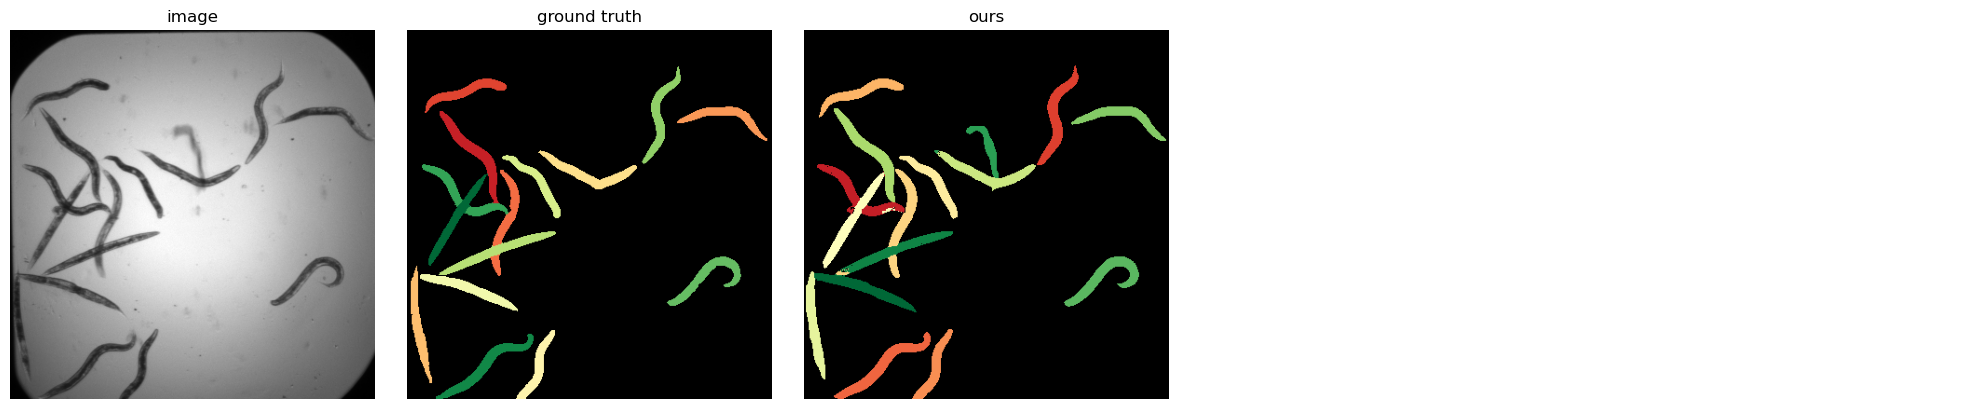

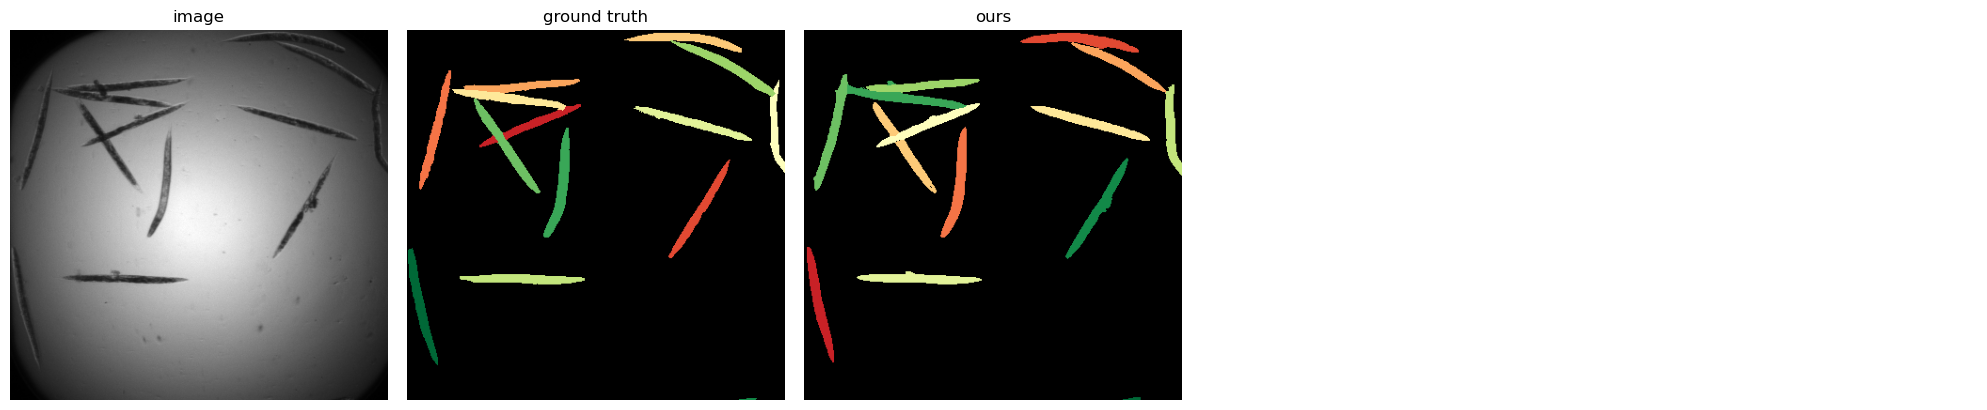

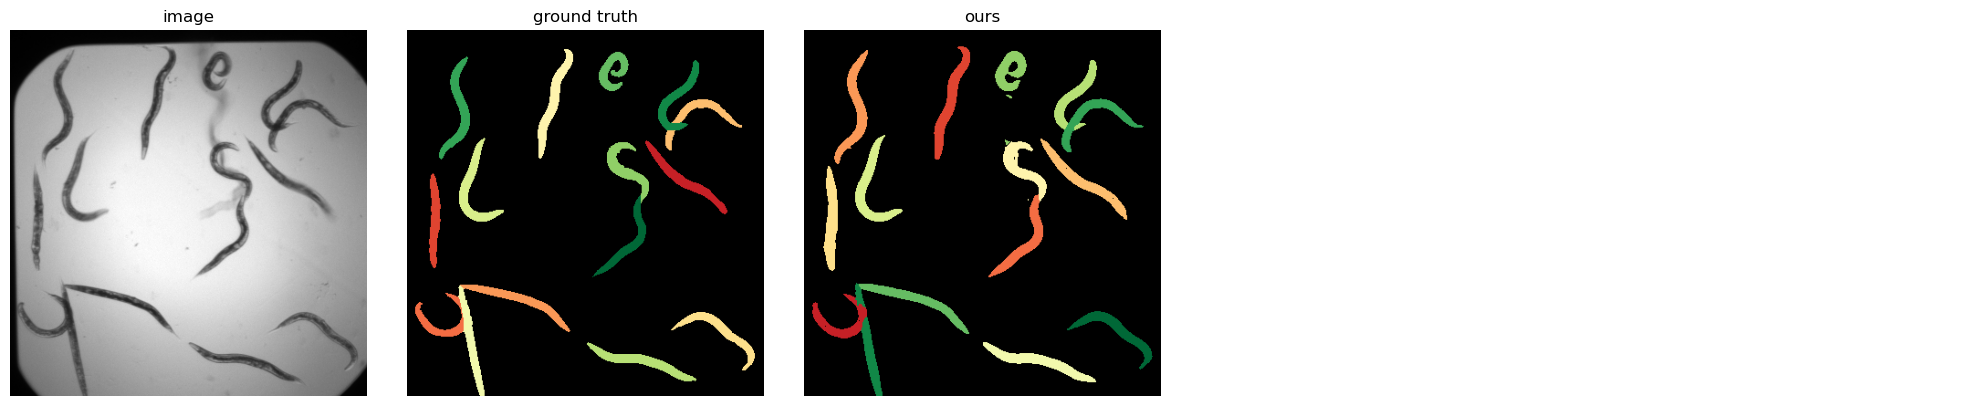

In [26]:
from collections import namedtuple
from crossgoose.mask_utils import relabel

image_names = list(images_d01.keys())

Figure = namedtuple('Figure', ['index','slicing'])
figures = [
    Figure(1,(slice(40,-40),slice(40,-40))),
    Figure(5,(slice(40,-40),slice(40,-40))),
    Figure(10,(slice(40,-40),slice(40,-40))),
]

res_dir = '../figs/results'
os.makedirs(res_dir,exist_ok=True)

for f in figures:
    n,m = 1, 5
    fig,axs = plt.subplots(n,m,figsize=(m*4,n*4),sharex=True,sharey=True,)
    name = image_names[f.index]

    [ax.set_axis_off() for ax in axs]
    if f.slicing:
        s = f.slicing
    else:
        s = (slice(None,None),slice(None,None))
    mask_true = masks_true_d01[name][s]
    image = images_d01[name][s]

    axs[0].imshow(image,cmap='gray')
    plt.imsave(os.path.join(res_dir,f"{name}_img.png"),image,cmap='gray')

    axs[0].set_title("image")
    axs[1].imshow(mask_true,cmap=cmap)
    plt.imsave(os.path.join(res_dir,f"{name}_mask_true.png"),mask_true,cmap=cmap)

    axs[1].set_title("ground truth")
    for i,model in enumerate(results_v01.keys()):
        try:
            mask_pred = results_v01[model]['masks'][name][s]
        except KeyError as e:
            mask_pred = results_v01[model]['masks'][name+'_img'][s]
            # print(name)
            # print(results_d01[model]['masks'].keys())
        mask_pred = relabel(mask_pred,shuffle=True,shuffle_seed=4)
        axs[i+2].imshow(mask_pred,cmap=cmap)
        plt.imsave(os.path.join(res_dir,f"{name}_mask_{model}.png"),mask_pred,cmap=cmap)
        axs[i+2].set_title(model)
    fig.tight_layout()

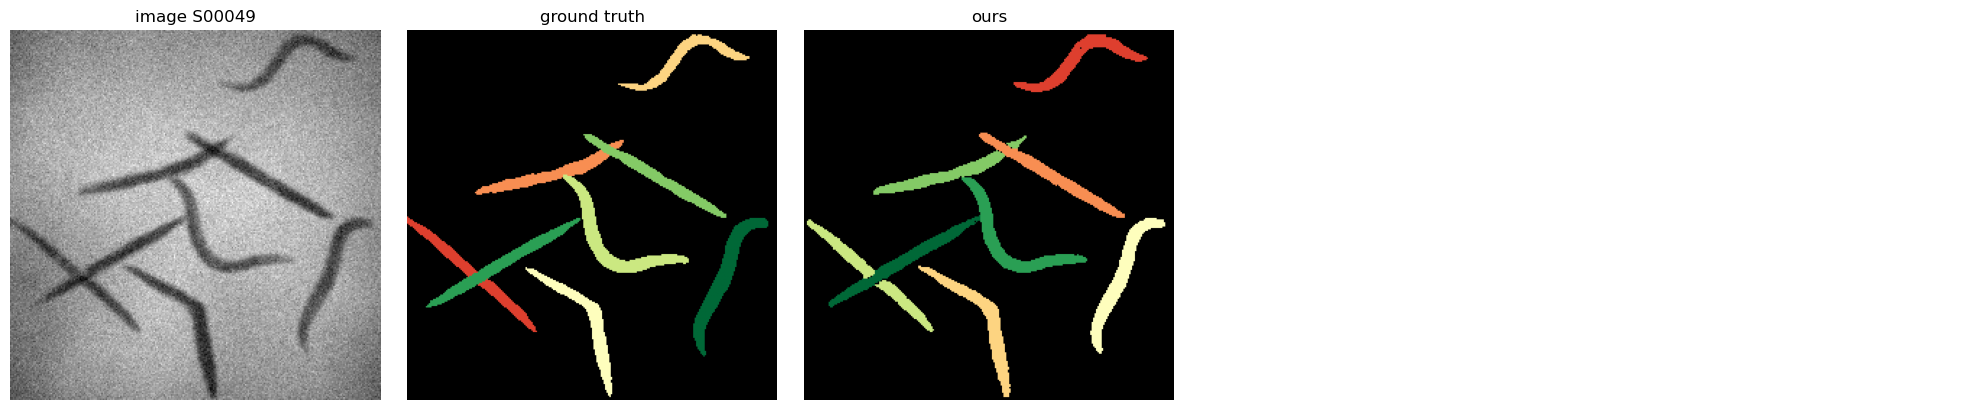

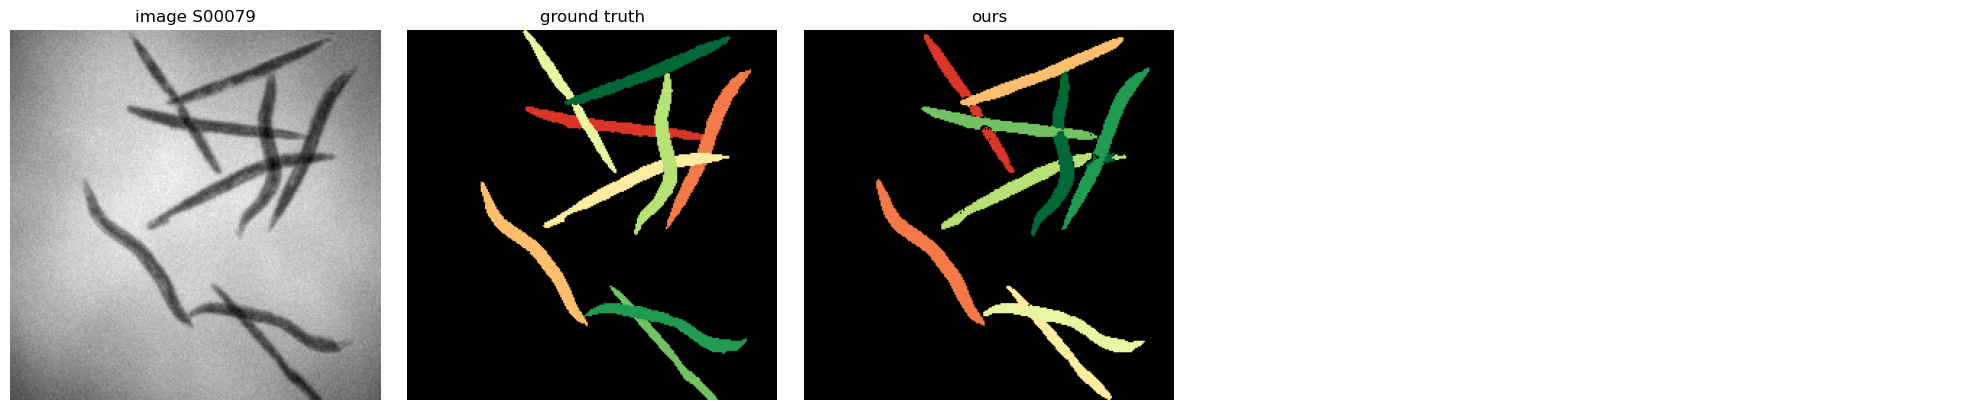

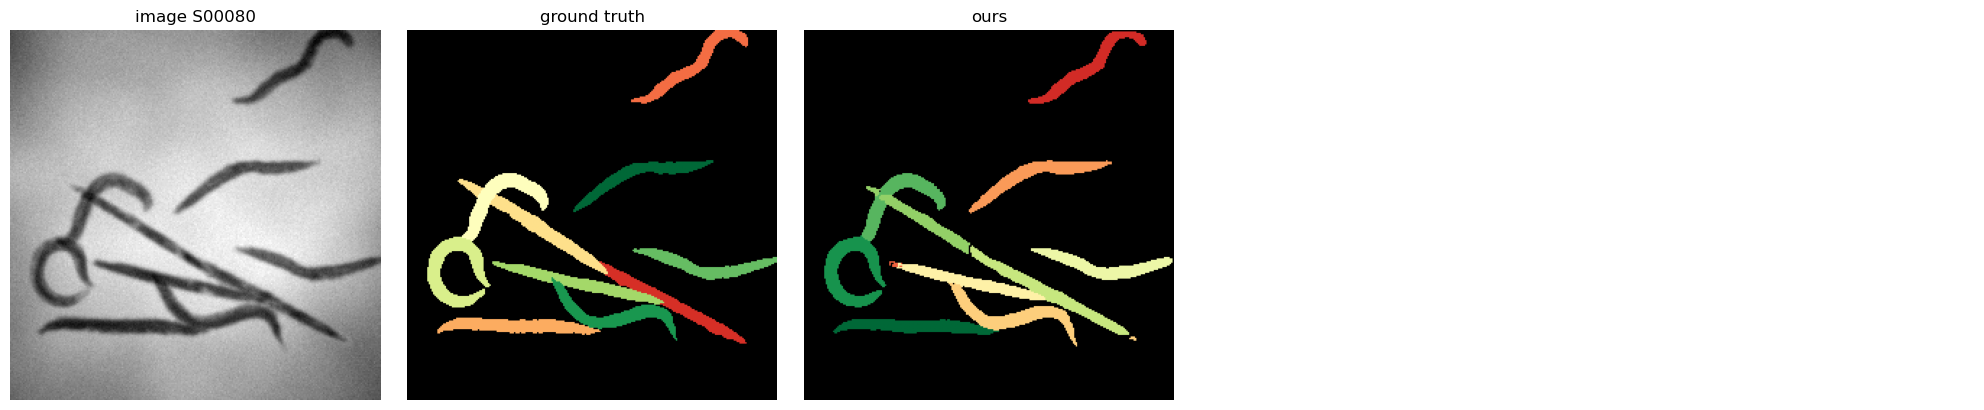

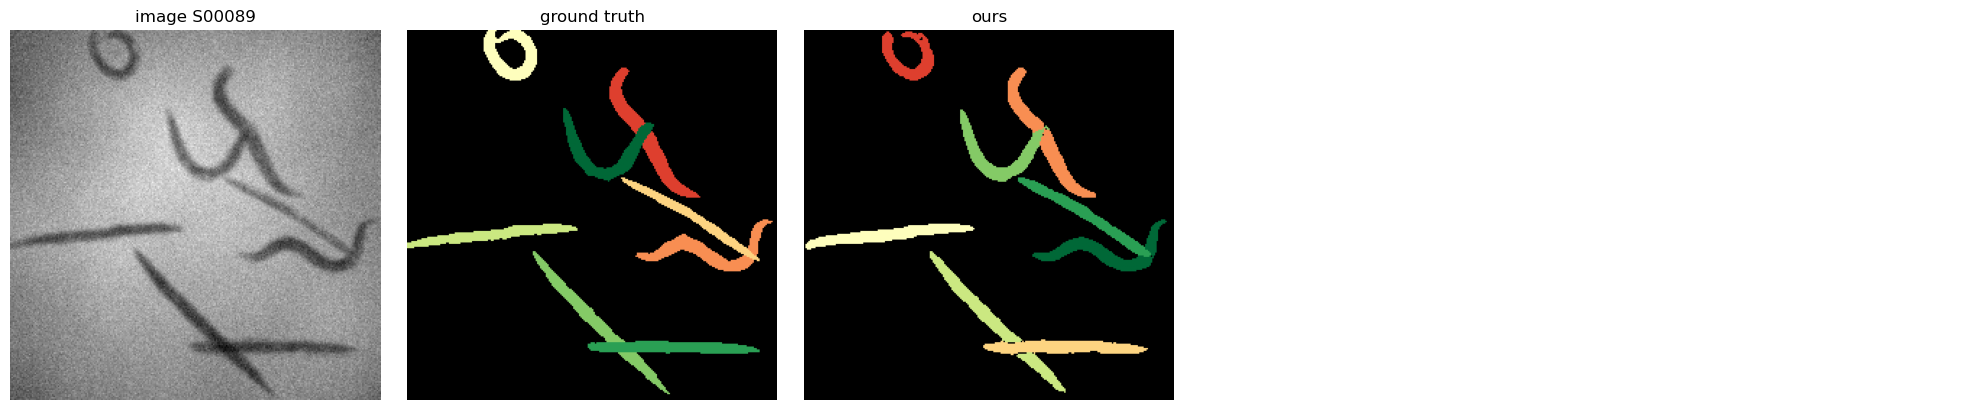

In [34]:
image_names = list(images_d05.keys())
Figure = namedtuple('Figure', ['index','slicing'])
figures = [
    Figure(100,None),
    Figure(130,None),
    Figure(131,None),
    Figure(140,None)
]

res_dir = '../figs/results'
os.makedirs(res_dir,exist_ok=True)

for f in figures:
    n,m = 1, 5
    fig,axs = plt.subplots(n,m,figsize=(m*4,n*4),sharex=True,sharey=True,)
    name = image_names[f.index]

    [ax.set_axis_off() for ax in axs]
    if f.slicing:
        s = f.slicing
    else:
        s = (slice(None,None),slice(None,None))
    mask_true = masks_true_d05[name][s]
    image = images_d05[name][s]

    axs[0].imshow(image,cmap='gray')
    plt.imsave(os.path.join(res_dir,f"{name}_img.png"),image,cmap='gray')

    axs[0].set_title(f"image {name}")
    axs[1].imshow(mask_true,cmap=cmap)
    plt.imsave(os.path.join(res_dir,f"{name}_mask_true.png"),mask_true,cmap=cmap)

    axs[1].set_title("ground truth")
    for i,model in enumerate(results_v02.keys()):
        try:
            mask_pred = results_v02[model]['masks'][name][s]
        except KeyError as e:
            mask_pred = results_v02[model]['masks'][name+'_img'][s]
            # print(name)
            # print(results_d01[model]['masks'].keys())
        mask_pred = relabel(mask_pred,shuffle=True,shuffle_seed=4)
        axs[i+2].imshow(mask_pred,cmap=cmap)
        plt.imsave(os.path.join(res_dir,f"{name}_mask_{model}.png"),mask_pred,cmap=cmap)
        axs[i+2].set_title(model)
    fig.tight_layout()